In [15]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

<p>Put fragment file path here...</p>

In [37]:
fragment_file = '../input/final/Beer_3_full1_5_2E5_pos_fragments.csv'
loss_file = None
# loss_file = '../input/final/Beer_3_full1_5_2E5_pos_losses.csv'
data = pd.DataFrame.from_csv(fragment_file)
if loss_file != None:
    loss_data = pd.DataFrame.from_csv(loss_file)
    data = pd.concat((data,loss_data),axis=0)

<p>Swap the NaNs for zeros. Turn into a numpy array and grab the parent names</p>

In [38]:
data = data.fillna(0)
data_array = np.array(data)
peak_names = list(data.columns.values)

<p>Create a matrix with the normalised values (each parent ion has magnitude 1)</p>

In [39]:
l = np.sqrt((data_array**2).sum(axis=0))
norm_data = np.divide(data_array,l)

In [40]:
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy

<p>Following cell does Scipy hierarchical clustering - either run this one, or the greedy version below</p>

In [41]:
clustering = hierarchy.fclusterdata(norm_data.transpose(),0.8,criterion = 'distance',metric='euclidean',method='single')
print "Found {} clusters".format(np.max(clustering))

Found 537 clusters


<p>Following cell does Greedy cosine clustering</p>

In [42]:
cosine_sim = np.dot(norm_data.transpose(),norm_data)
finished = False
total_intensity = data_array.sum(axis=0)
total_intensity = total_intensity
n_features,n_parents = data_array.shape
clustering = np.zeros((n_parents,),np.int)
current_cluster = 1
thresh = 0.7
count = 0
while not finished:
#     Find the parent with the max intensity left
    current = np.argmax(total_intensity)
    total_intensity[current] = 0.0
    count += 1
    clustering[current] = current_cluster
#     Find other parents with cosine similarity over the threshold
    friends = np.where((cosine_sim[current,:]>thresh) * (total_intensity > 0.0))[0]
    clustering[friends] = current_cluster
    total_intensity[friends] = 0.0
#     When points are clustered, their total_intensity is set zto zero. If there is nothing left with zero, quit
    left = np.where(total_intensity > 0.0)[0]
    if len(left) == 0:
        finished = True
    current_cluster += 1

In [43]:
import networkx as nx
from networkx.algorithms import bipartite

<p>create the networkx graph object. Note that clusters with fewer than min_size_to_plot members are not plotted</p>

In [30]:
min_size_to_plot = 3
node_no = 0
G = nx.Graph()
uc = np.unique(clustering)
cluster_nodes = {}
singleton_clusters = []
for cluster in uc:
    members = np.where(clustering == cluster)[0]
    if len(members) < min_size_to_plot:
        singleton_clusters.append(cluster)
        continue
    cluster_nodes[cluster] = node_no
    G.add_node(node_no,bipartite=0)
    node_no += 1

peak_nodes = {}
for i,name in enumerate(peak_names):
    this_cluster = clustering[i]
    if this_cluster in cluster_nodes:
        peak_nodes[name] = node_no
        G.add_node(node_no,bipartite=1)
        G.add_edge(node_no,cluster_nodes[clustering[i]])
        node_no += 1



<p>Position the clusters in a grid, and their members in circle coming out from the cluster. cstep determines the distance between grid points. If you want cluster members closer to the cluster centers, change the 0.75 in the x_pos and y_pos lines</p>

In [31]:
C,P = bipartite.sets(G)
n_clusters = len(C)
n_rows = np.ceil(np.sqrt(n_clusters))
pos = {}
current_row = 0
current_col = 0
cstep = 2.0
for c in C:
    n_list = G.neighbors(c)
    pos[c] = [cstep*current_row,cstep*current_col]
#     find neighbours
    step = 2*np.pi/len(n_list)
    angle = 0.0
    for n in n_list:
        x_pos = 0.75*np.sin(angle)
        y_pos = 0.75*np.cos(angle)
        pos[n] = [pos[c][0]+x_pos,pos[c][1]+y_pos]
        angle += step
    current_col += 1
    if current_col >= n_rows:
        current_col = 0
        current_row += 1
    

<p>A function for drawing the network - pass it a graph object, a dictionary of node positions, the two sets of nodes (clusters and parents), and a list of the node ids for any parent ions of interest</p>

In [32]:
def draw_network(G,pos,C,P,interest_nodes,output_name,title):
    nx.draw_networkx_edges(G,pos,width=0.2)
    nx.draw_networkx_nodes(G,pos,nodelist=C,node_size = 1,node_color = 'g',linewidths=0.1)
    nx.draw_networkx_nodes(G,pos,nodelist=P,node_size = 0.5,node_color = 'b',linewidths=0.1)
    nx.draw_networkx_nodes(G,pos,nodelist=interest_nodes,node_size=2,node_color='r',linewidths=0.1)
    plt.title(title)
    plt.axis('off')
    plt.savefig(output_name)

In [74]:
def disp_clusters(clustering,ions_of_interest,peak_names):
    peak_clusters = {}
    for i in ions_of_interest:
        pos = [j for j,n in enumerate(peak_names) if n == i][0]
        peak_clusters[i] = clustering[pos]

    import operator
    sorted_dict = sorted(peak_clusters.items(),key = operator.itemgetter(1))
    
    print "Parents sorted by cluster:"
    for i in sorted_dict:
        print i
    

<p>Plot the networks for topics 3, 121 and 240 as per email from Justin</p>

Parents sorted by cluster:
('195.08761_510.903_6406', 99)
('235.11886_398.577_9934', 225)
('235.11867_414.273_9908', 225)
('235.10771_409.09_9882', 225)
('364.1613_428.341_18634', 253)
('310.21252_240.354_16139', 259)
('198.11249_458.36_6829', 259)
('198.08729_481.308_6733', 259)
('553.30972_304.981_21426', 259)
('156.07679_752.304_3316', 259)
('156.07677_621.074_3303', 259)
('277.15852_427.098_13504', 259)
('251.14993_409.09_11259', 259)
('277.1474_435.83_13480', 259)
('480.18217_599.71_20955', 267)
('110.07129_621.074_324', 300)
('364.16145_465.819_18641', 379)
('362.21659_503.147_18445', 510)
('522.2161_463.346_21244', 676)
('522.21623_469.707_21247', 676)


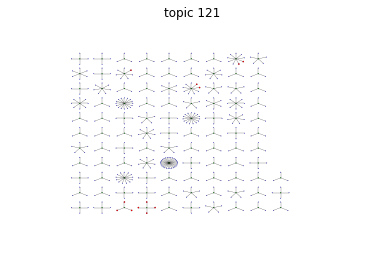

In [75]:
ions_of_interest_121 = ['235.11886_398.577_9934',
'235.11867_414.273_9908',
'235.10771_409.09_9882',
'553.30972_304.981_21426',
'310.21252_240.354_16139',
'277.1474_435.83_13480',
'277.15852_427.098_13504',
'156.07679_752.304_3316',
'251.14993_409.09_11259',
'156.07677_621.074_3303',
'198.08729_481.308_6733',
'110.07129_621.074_324',
'362.21659_503.147_18445',
'198.11249_458.36_6829',
'364.16145_465.819_18641',
'364.1613_428.341_18634',
'195.08761_510.903_6406',
'480.18217_599.71_20955',
'522.2161_463.346_21244',
'522.21623_469.707_21247'
]
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_121]
draw_network(G,pos,C,P,interest_nodes,'euclidean_121.pdf','topic 121')
disp_clusters(clustering,ions_of_interest_121,peak_names)

Parents sorted by cluster:
('152.07054_491.622_3029', 101)
('246.07935_398.577_10863', 187)
('300.14413_595.985_15468', 187)
('152.12813_395.725_3095', 187)
('246.07926_409.09_10848', 187)
('166.08626_290.373_4191', 187)
('166.12265_282.677_4258', 187)
('246.13339_410.326_10880', 187)
('152.10698_260.221_3062', 187)
('166.1226_692.788_4241', 187)
('328.17553_652.517_16968', 187)
('152.10695_198.223_3045', 187)
('232.06382_549.717_9778', 203)
('314.15956_409.09_16346', 203)
('138.09137_459.598_2061', 203)
('180.10186_355.669_5307', 205)
('471.23791_207.077_20922', 230)
('513.18921_208.313_21149', 301)
('314.15894_851.554_16340', 301)
('121.06479_260.221_799', 301)
('121.06478_199.485_784', 301)
('121.06482_459.598_809', 301)
('152.0376_389.139_2963', 301)
('121.06484_448.381_818', 301)
('121.06478_699.082_792', 301)
('180.13823_1067.42_5365', 301)
('314.13861_269.685_16325', 364)
('166.04983_421.989_4119', 375)
('404.20663_240.354_20189', 427)
('138.04915_482.766_1990', 432)
('138.04296

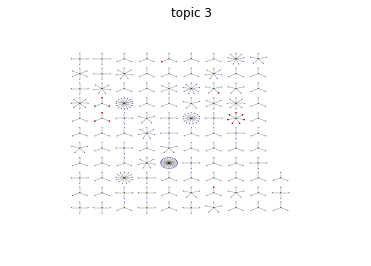

In [76]:
ions_of_interest_3 = ['314.15894_851.554_16340',
'513.18921_208.313_21149',
'666.51234_218.245_21676',
'666.5124_225.864_21683',
'538.28021_240.354_21342',
'232.06382_549.717_9778',
'328.17553_652.517_16968',
'121.06484_448.381_818',
'121.06482_459.598_809',
'121.06478_199.485_784',
'390.21183_469.707_19966',
'246.07926_409.09_10848',
'246.07935_398.577_10863',
'314.15956_409.09_16346',
'152.12813_395.725_3095',
'138.09137_459.598_2061',
'138.04915_482.766_1990',
'138.04296_484.002_1973',
'152.0376_389.139_2963',
'180.13823_1067.42_5365',
'152.10695_198.223_3045',
'152.10698_260.221_3062',
'300.14413_595.985_15468',
'166.1226_692.788_4241',
'121.06478_699.082_792',
'121.06479_260.221_799',
'246.13339_410.326_10880',
'471.23791_207.077_20922',
'318.15479_432.107_16447',
'404.20663_240.354_20189',
'314.13861_269.685_16325',
'166.12265_282.677_4258',
'166.08626_290.373_4191',
'152.07054_491.622_3029',
'166.08628_377.302_4202',
'166.04983_421.989_4119',
'180.10186_355.669_5307']
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_3]
draw_network(G,pos,C,P,interest_nodes,'euclidean_3.pdf','topic 3')
disp_clusters(clustering,ions_of_interest_3,peak_names)

Parents sorted by cluster:
('414.19697_313.227_20264', 52)
('414.19662_411.615_20250', 85)
('397.17058_314.478_20080', 85)
('829.28121_676.494_21818', 100)
('603.15348_657.516_21552', 100)
('371.1549_514.793_19276', 100)
('580.20871_656.24_21497', 100)
('684.25548_677.736_21758', 100)
('846.30793_686.519_21828', 100)
('487.16565_661.235_20989', 100)
('649.21868_677.736_21623', 100)
('991.33379_689.007_21848', 100)
('1009.34458_661.235_21873', 100)
('667.22894_676.494_21709', 100)
('505.1764_661.235_21097', 100)
('522.20268_659.996_21182', 100)
('667.2285_666.373_21690', 100)
('829.28091_685.234_21808', 100)
('360.14987_655.001_18389', 100)
('388.18119_514.793_19928', 100)
('342.13944_670.092_17345', 100)
('1026.3715_663.894_21884', 100)
('1008.361_689.007_21858', 100)
('522.2028_670.092_21213', 100)
('242.12327_552.287_10533', 156)
('486.18187_520.976_20980', 164)
('342.13951_553.527_17356', 164)
('342.13953_542.28_17366', 164)
('525.21116_666.373_21250', 191)
('270.15453_478.834_12801

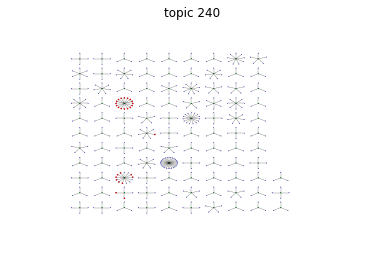

In [77]:
ions_of_interest_240 = ['414.19697_313.227_20264',
'1026.3715_663.894_21884',
'1008.361_689.007_21858',
'991.33379_689.007_21848',
'432.20761_514.793_20469',
'279.15477_366.931_13715',
'279.15486_379.781_13721',
'1009.34458_661.235_21873',
'846.30793_686.519_21828',
'434.18699_648.791_20506',
'486.18187_520.976_20980',
'525.21116_666.373_21250',
'580.20871_656.24_21497',
'684.25548_677.736_21758',
'829.28121_676.494_21818',
'829.28091_685.234_21808',
'342.13953_542.28_17366',
'342.13951_553.527_17356',
'388.18119_514.793_19928',
'522.2028_670.092_21213',
'522.20268_659.996_21182',
'667.22894_676.494_21709',
'667.2285_666.373_21690',
'360.14987_655.001_18389',
'649.21868_677.736_21623',
'342.13944_670.092_17345',
'505.1764_661.235_21097',
'603.15348_657.516_21552',
'270.11823_554.77_12793',
'371.1549_514.793_19276',
'487.16565_661.235_20989',
'198.0972_696.582_6750',
'397.17058_314.478_20080',
'325.11294_514.793_16684',
'270.15453_478.834_12801',
'270.15454_467.234_12831',
'270.09467_465.819_12761',
'242.12327_552.287_10533',
'414.19662_411.615_20250',
'388.14759_489.128_19917',
'180.08662_562.308_5249']
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_240]
draw_network(G,pos,C,P,interest_nodes,'euclidean_240.pdf','topic 240')
disp_clusters(clustering,ions_of_interest_240,peak_names)

Parents sorted by cluster:
('128.07057_402.687_1202', 56)
('128.07049_418.038_1177', 56)
('118.08625_365.689_694', 96)
('118.08626_378.542_699', 96)
('160.09682_365.689_3575', 109)
('271.08106_368.171_12861', 126)
('271.08108_379.781_12869', 126)
('130.04987_630.064_1292', 127)
('130.06922_631.311_1342', 127)
('132.06546_567.288_1614', 153)
('240.12294_257.728_10348', 154)
('116.0706_874.873_584', 159)
('116.07061_433.349_589', 159)
('118.07713_578.503_671', 159)
('116.07054_577.268_573', 159)
('190.10731_381.023_5987', 161)
('190.10735_334.186_6013', 161)
('190.10733_398.577_6000', 161)
('130.08627_566.043_1357', 206)
('210.1124_244.41_7724', 243)
('131.08957_567.288_1528', 255)
('156.07679_752.304_3316', 259)
('156.07677_621.074_3303', 259)
('130.04989_484.002_1307', 264)
('144.06558_452.144_2208', 299)
('186.07607_381.023_5643', 315)
('117.07383_577.268_622', 328)
('222.11237_287.883_8511', 331)
('146.08116_472.407_2473', 371)
('172.06044_487.891_4530', 381)
('129.0658_631.311_1256'

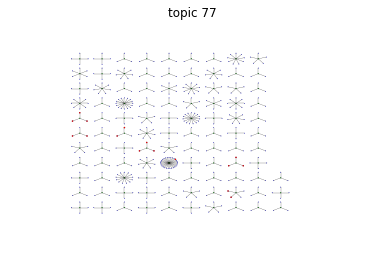

In [78]:
ions_of_interest_77 = [
    '578.22669_264.331_21495',
    '117.07383_577.268_622',
    '116.07054_577.268_573',
    '128.07066_563.553_1220',
    '116.0706_874.873_584',
    '131.05323_484.002_1479',
    '127.05019_519.739_1081',
    '172.09678_458.36_4545',
    '172.09682_448.381_4555',
    '116.07061_433.349_589',
    '130.08627_566.043_1357',
    '130.04989_484.002_1307',
    '131.08957_567.288_1528',
    '132.10191_519.739_1697',
    '132.10198_533.567_1708',
    '129.0658_631.311_1256',
    '156.07679_752.304_3316',
    '160.09676_419.279_3570',
    '188.12805_297.137_5779',
    '146.11759_486.476_2596',
    '118.08625_365.689_694',
    '118.08626_378.542_699',
    '157.0801_621.074_3358',
    '144.06552_299.618_2191',
    '188.12806_406.431_5787',
    '132.06553_619.834_1634',
    '144.06558_452.144_2208',
    '156.07677_621.074_3303',
    '157.06076_510.903_3329',
    '133.0688_567.288_1768',
    '174.07612_547.239_4693',
    '174.07611_539.755_4687',
    '228.12298_264.331_9265',
    '188.12808_361.963_5800',
    '160.09686_552.287_3612',
    '160.09671_569.777_3562',
    '243.13386_361.963_10622',
    '170.09238_558.499_4406',
    '132.06546_567.288_1614',
    '172.06044_487.891_4530',
    '146.08116_472.407_2473',
    '222.11237_287.883_8511',
    '186.07607_381.023_5643',
    '210.1124_244.41_7724',
    '130.06922_631.311_1342',
    '190.10733_398.577_6000',
    '190.10731_381.023_5987',
    '117.05454_410.326_599',
    '160.09682_365.689_3575',
    '190.10735_334.186_6013',
    '240.12294_257.728_10348',
    '148.09676_508.423_2782',
    '128.07049_418.038_1177',
    '128.07057_402.687_1202',
    '271.08106_368.171_12861',
    '271.08108_379.781_12869',
    '118.07713_578.503_671',
    '130.04987_630.064_1292'   
]
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_77]
draw_network(G,pos,C,P,interest_nodes,'euclidean_77.pdf','topic 77')
disp_clusters(clustering,ions_of_interest_77,peak_names)